In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bm=0, bs=32, n_test=1000000)

In [ ]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=2e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),EarlyStopping(5)])

model.save('weights/BCE_Test.h5')

1: Train=0.3878478986597061 Valid=0.3497459635782242


KeyboardInterrupt: 

In [ ]:
model.load('weights/BCE_Test.h5')

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 4.weight: copying a param with shape torch.Size([10, 100]) from checkpoint, the shape in current model is torch.Size([1, 100]).
	size mismatch for 4.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([1]).

## BM 0

In [ ]:
preds = model.predict(test)

In [ ]:
preds

array([[0.20870802],
       [0.89103824],
       [0.41690648],
       ...,
       [0.67952925],
       [0.14806537],
       [0.00552799]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.208708,1.0
1,0.891038,1.0
2,0.416906,1.0
3,0.868708,1.0
4,0.865787,1.0


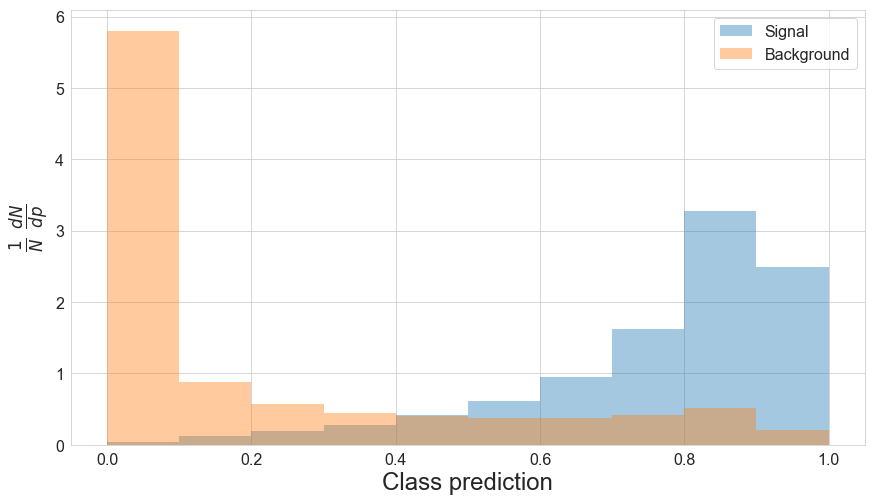

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df, np.linspace(0,1,11))

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.208708,1.0,2
1,0.891038,1.0,8
2,0.416906,1.0,4
3,0.868708,1.0,8
4,0.865787,1.0,8


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([1.6290e-02, 1.9344e-02, 2.7912e-02, 4.1124e-02, 6.0780e-02, 9.5616e-02,
         1.6237e-01, 3.2770e-01, 2.4886e-01, 2.0000e-13]),
 tensor([6.6872e-01, 5.7206e-02, 4.5114e-02, 3.9790e-02, 3.7924e-02, 3.8204e-02,
         4.1328e-02, 5.1208e-02, 2.0506e-02, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([6.6953e+02, 5.8173e+01, 4.6510e+01, 4.1846e+01, 4.0963e+01, 4.2985e+01,
         4.9447e+01, 6.7593e+01, 3.2949e+01, 2.1000e-10]), tensor(1050.0001))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([29.11978912, 28.96489716, 28.81610107, 28.6739502 , 28.53720856,
       28.40723419, 28.28320312, 28.16455078, 28.05216217, 27.94522095,
       27.84369659, 27.74823761, 27.65802002, 27.57296753, 27.49369812,
       27.41956329, 27.35036469, 27.28629303, 27.22784424, 27.17430878,
       27.12519073, 27.08158875, 27.0428009 , 27.00814056, 26.97892761,
       26.95435333, 26.93374634, 26.91838837, 26.907547  , 26.90067291,
       26.89875793, 26.90042114, 26.90714264, 26.91819763, 26.93267822,
       26.9520874 , 26.9756546 , 27.00255585, 27.03425598, 27.06996918,
       27.10914612, 27.15274048, 27.19995117, 27.25077057, 27.30587006,
       27.36454773, 27.42670441, 27.49301147, 27.56272888, 27.63584137,
       27.71298218, 27.7937088 , 27.87725067, 27.96494293, 28.05612183,
       28.15019989, 28.24794006, 28.34877777, 28.45343018, 28.56113434,
       28.67183685])

In [ ]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [ ]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

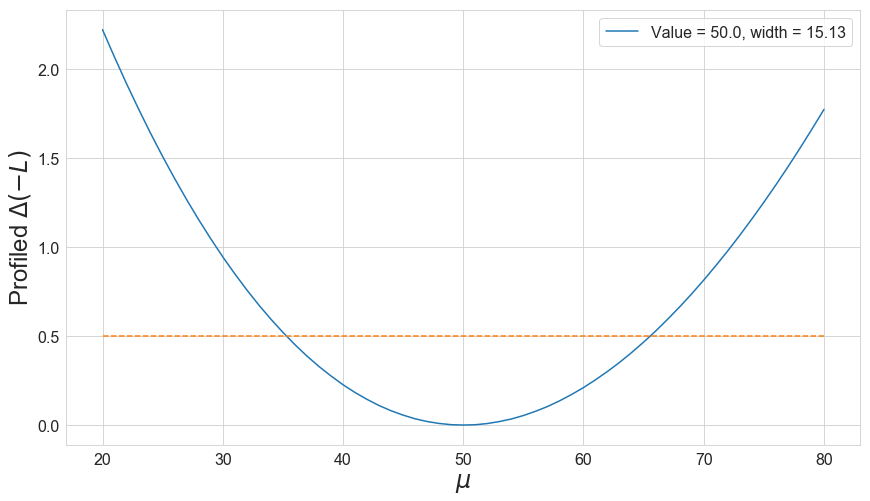

In [ ]:
plot_likelihood(y-y.min())

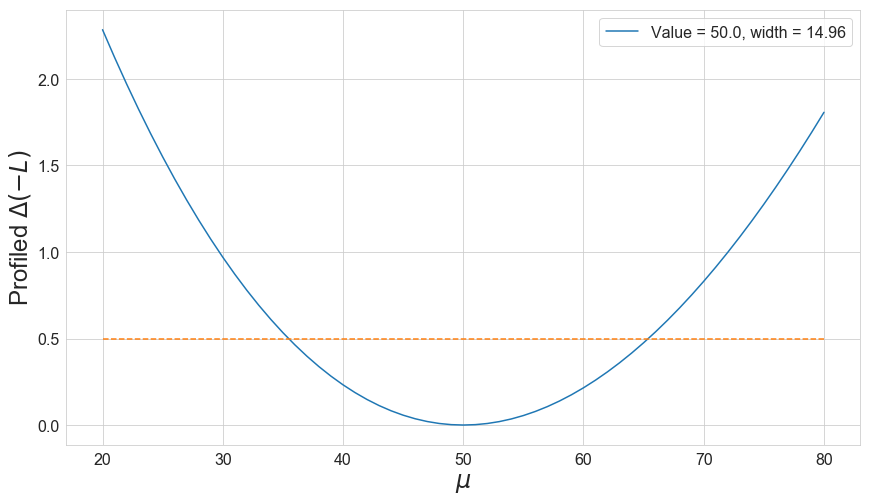

In [ ]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, bins=np.linspace(0,1,11))

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0.208708,1.0,2,0.208708,2,0.208708,2,0.208708,2,0.208708,2,0.208708,2
1,0.891038,1.0,8,0.891038,8,0.891038,8,0.891038,8,0.891038,8,0.891038,8
2,0.416906,1.0,4,0.416906,4,0.416906,4,0.416906,4,0.416906,4,0.416906,4
3,0.868708,1.0,8,0.868708,8,0.868708,8,0.868708,8,0.868708,8,0.868708,8
4,0.865787,1.0,8,0.865787,8,0.865787,8,0.865787,8,0.865787,8,0.865787,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.112387,0.0,1,0.139352,1,0.112387,1,0.085199,0,0.111992,1,0.112790,1
999996,0.001663,0.0,0,0.001901,0,0.001663,0,0.001446,0,0.001478,0,0.001886,0
999997,0.679529,0.0,6,0.756411,7,0.679529,6,0.592742,5,0.676851,6,0.682196,6
999998,0.148065,0.0,1,0.146445,1,0.148065,1,0.148029,1,0.145085,1,0.151482,1


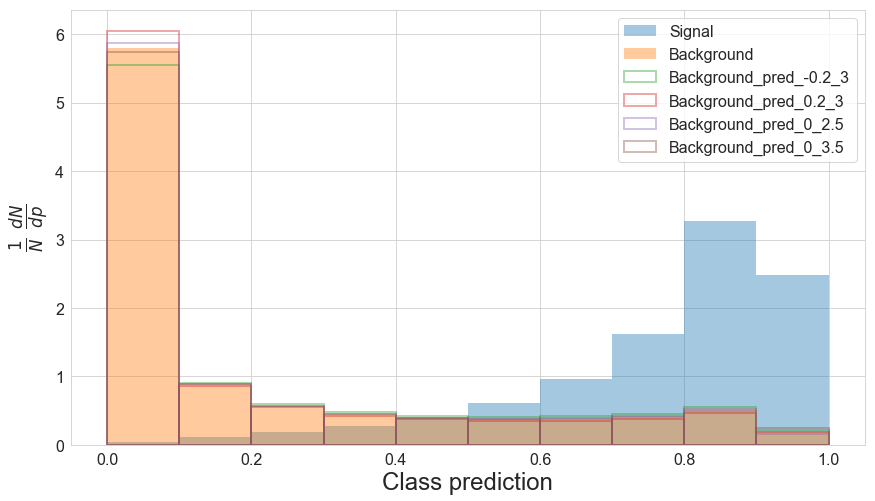

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [ ]:
b_shapes['f_b_nom']

tensor([6.6872e-01, 5.7206e-02, 4.5114e-02, 3.9790e-02, 3.7924e-02, 3.8204e-02,
        4.1328e-02, 5.1208e-02, 2.0506e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[6.9112e-01, 5.4744e-02, 4.2648e-02, 3.7718e-02, 3.4922e-02, 3.5186e-02,
         3.8178e-02, 4.6748e-02, 1.8738e-02, 2.0000e-13],
        [6.6185e-01, 5.6978e-02, 4.5526e-02, 3.9888e-02, 3.8166e-02, 3.8508e-02,
         4.1792e-02, 5.2526e-02, 2.4762e-02, 2.0000e-13]])

In [ ]:
b_shapes['f_b_dw']

tensor([[6.4622e-01, 5.9660e-02, 4.7592e-02, 4.2224e-02, 4.0282e-02, 4.1590e-02,
         4.4738e-02, 5.5402e-02, 2.2296e-02, 2.0000e-13],
        [6.7557e-01, 5.7346e-02, 4.4840e-02, 3.9678e-02, 3.7640e-02, 3.7892e-02,
         4.0820e-02, 4.9754e-02, 1.6460e-02, 2.0000e-13]])

In [ ]:
f_s

tensor([1.6290e-02, 1.9344e-02, 2.7912e-02, 4.1124e-02, 6.0780e-02, 9.5616e-02,
        1.6237e-01, 3.2770e-01, 2.4886e-01, 2.0000e-13])

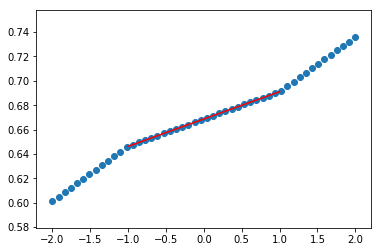

In [ ]:
i = 0
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

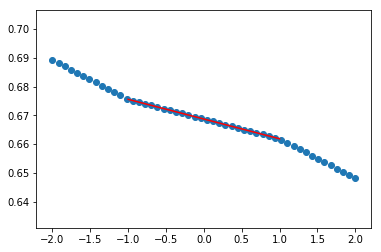

In [ ]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [ ]:
b_shapes['f_b_nom']

tensor([6.6872e-01, 5.7206e-02, 4.5114e-02, 3.9790e-02, 3.7924e-02, 3.8204e-02,
        4.1328e-02, 5.1208e-02, 2.0506e-02, 2.0000e-13])

In [ ]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([6.9112e-01, 5.4744e-02, 4.2648e-02, 3.7718e-02, 3.4922e-02, 3.5186e-02,
        3.8178e-02, 4.6748e-02, 1.8738e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[6.9112e-01, 5.4744e-02, 4.2648e-02, 3.7718e-02, 3.4922e-02, 3.5186e-02,
         3.8178e-02, 4.6748e-02, 1.8738e-02, 2.0000e-13],
        [6.6185e-01, 5.6978e-02, 4.5526e-02, 3.9888e-02, 3.8166e-02, 3.8508e-02,
         4.1792e-02, 5.2526e-02, 2.4762e-02, 2.0000e-13]])

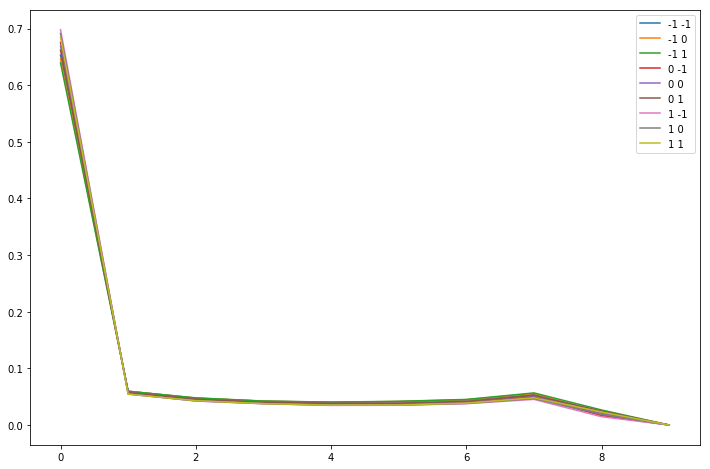

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

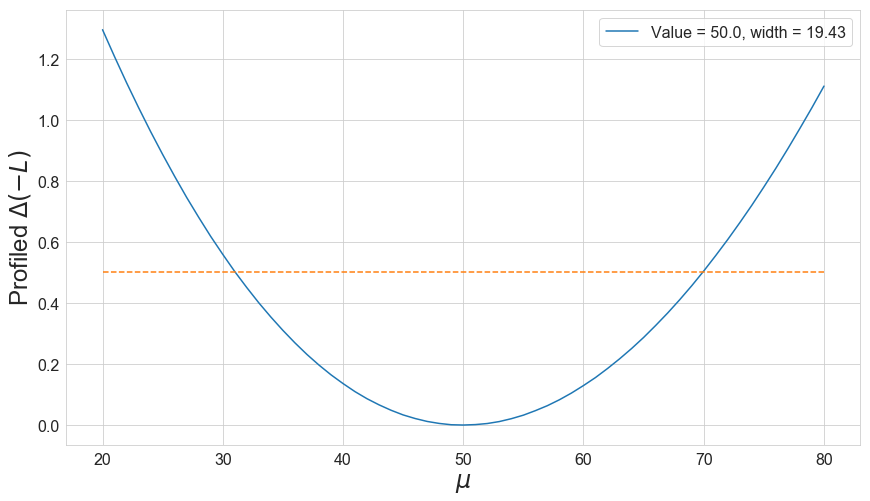

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

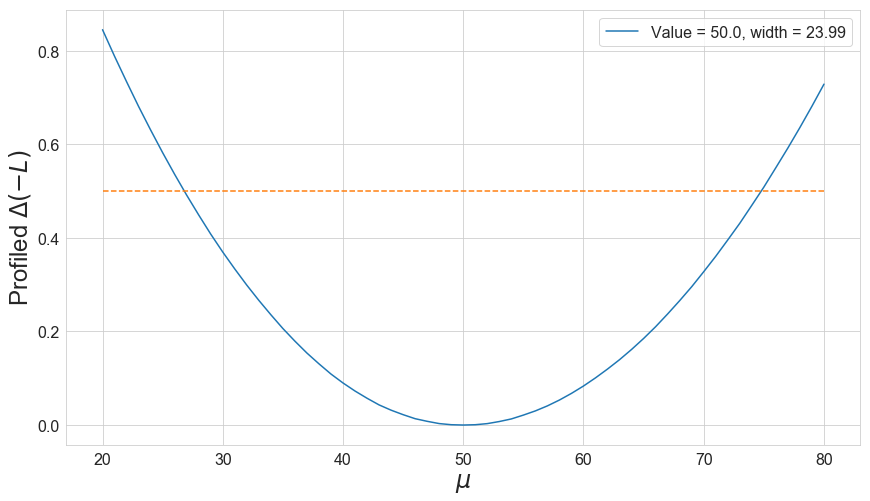

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

In [ ]:
nll, nll.min()

(array([ 27.6017  ,  27.554985,  27.509361,  27.46595 ,  27.424408,
         27.384224,  27.345505,  27.30867 ,  27.273407,  27.23951 ,
         27.207458,  27.176842,  27.147537,  27.120445,  27.09449 ,
         27.070465,  27.047935,  27.034203,  27.054825,  27.033745,
         27.103851,  27.027176,  27.04229 ,  27.07441 ,  27.126549,
         27.11615 ,        nan,        nan,        nan,        nan,
         26.898758, 204.65234 , 971.2236  ,        nan,        nan,
               nan, 356.52518 ,        nan,        nan,  29.523636,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,  27.112396,        nan,        nan,
               nan,        nan,        nan,  27.272972,        nan,
         27.340485,  27.376167,  27.41298 ,  27.45134 ,  27.491188,
         27.531502], dtype=float32), nan)

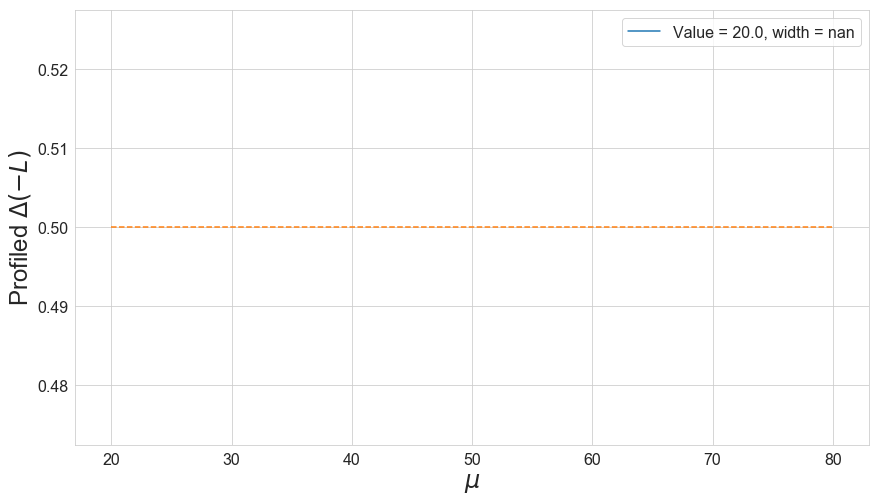

In [ ]:
plot_likelihood(nll-nll.min())